In [1]:
!wget http://data.insideairbnb.com/united-states/tx/austin/2019-11-12/data/listings.csv.gz

--2020-01-08 19:12:07--  http://data.insideairbnb.com/united-states/tx/austin/2019-11-12/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.168.18
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.168.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11223947 (11M) [application/x-gzip]
Saving to: ‘listings.csv.gz’

listings.csv.gz     100%[===================>]  10.70M  31.9MB/s    in 0.3s    

2020-01-08 19:12:07 (31.9 MB/s) - ‘listings.csv.gz’ saved [11223947/11223947]



In [0]:
!gunzip listings.csv.gz

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Clean and engineer data

In [5]:
df = pd.read_csv('listings.csv')

print(df.shape)
df.head()

(11250, 106)


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (43,61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,extra_people,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2265,https://www.airbnb.com/rooms/2265,20191112224534,2019-11-13,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,$30.00,30,90,30,30,90,90,30.0,90.0,3 months ago,t,0,0,0,0,2019-11-13,24,1,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0,10.0,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18
1,5245,https://www.airbnb.com/rooms/5245,20191112224534,2019-11-13,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,Please note: A two story studio was built in t...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,$35.00,30,60,30,30,60,60,30.0,60.0,5 months ago,t,0,0,0,0,2019-11-13,9,0,2009-03-19,2018-03-14,91.0,10.0,8.0,10.0,9.0,10.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07
2,5456,https://www.airbnb.com/rooms/5456,20191112224534,2019-11-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...

In [6]:
free_rentals = list(df[df['price'] == "$0.00"].index)

df = df.drop(index=free_rentals)

print(df.shape)

(11244, 106)


In [7]:
df['price'] = df['price'].apply(lambda p: float(p.strip('$').replace(",",'')))

df['price'].describe()

count    11244.000000
mean       429.080398
std       1296.041387
min          1.000000
25%         80.000000
50%        140.000000
75%        300.000000
max      17999.000000
Name: price, dtype: float64

In [8]:
def am_to_list(amenities):
    li = amenities.split(",")

    for i in range(len(li)):
        li[i] = li[i].replace('"', '')
        li[i] = li[i].replace("'", '')
        li[i] = li[i].strip("{")
        li[i] = li[i].strip("}")

    return li

df['am_list'] = df['amenities'].apply(am_to_list)

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,minimum_nights,maximum_nights,minimum_minimum_nights,maximum_minimum_nights,minimum_maximum_nights,maximum_maximum_nights,minimum_nights_avg_ntm,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,am_list
0,2265,https://www.airbnb.com/rooms/2265,20191112224534,2019-11-13,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,30,90,30,30,90,90,30.0,90.0,3 months ago,t,0,0,0,0,2019-11-13,24,1,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0,10.0,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
1,5245,https://www.airbnb.com/rooms/5245,20191112224534,2019-11-13,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,Please note: A two story studio was built in t...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,30,60,30,30,60,60,30.0,60.0,5 months ago,t,0,0,0,0,2019-11-13,9,0,2009-03-19,2018-03-14,91.0,10.0,8.0,10.0,9.0,10.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07,"[TV, Cable TV, Internet, Wifi, Air conditionin..."
2,5456,https://www.airbnb.com/rooms/5456,20191112224534,2019-11-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private 

In [9]:
potential_features = ['Air conditioning',
                      'Dishwasher', 'Free parking on premises',
                      'Kitchen', 'Garden or backyard',
                      'Internet',
                      'Suitable for events']

for feature in potential_features:
    df[feature] = df['am_list'].apply(lambda li: feature in li)
    
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,maximum_nights_avg_ntm,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,number_of_reviews_ltm,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,am_list,Air conditioning,Dishwasher,Free parking on premises,Kitchen,Garden or backyard,Internet,Suitable for events
0,2265,https://www.airbnb.com/rooms/2265,20191112224534,2019-11-13,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,90.0,3 months ago,t,0,0,0,0,2019-11-13,24,1,2009-03-17,2019-03-16,93.0,9.0,10.0,10.0,10.0,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18,"[TV, Cable TV, Internet, Wifi, Air conditionin...",True,False,True,True,True,True,False
1,5245,https://www.airbnb.com/rooms/5245,20191112224534,2019-11-13,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,Please note: A two story studio was built in t...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,60.0,5 months ago,t,0,0,0,0,2019-11-13,9,0,2009-03-19,2018-03-14,91.0,10.0,8.0,10.0,9.0,10.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07,"[TV, Cable TV, Internet, Wifi, Air conditionin...",True,False,True,True,False,True,False
2,5456,https://www.airbnb.com/rooms/5456,20191112224534,2019-11-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio 

In [0]:
df['entire'] = df['room_type'] == 'Entire home/apt'
df['private'] = df['room_type'] == 'Private room'
df['shared'] = df['room_type'] == 'Shared room'
df['hotel'] = df['room_type'] == 'Hotel room'

In [11]:
cutoff = 10
top_hoods = df['neighbourhood'].value_counts(dropna=True).index[:cutoff]

for hood in top_hoods:
    df[hood] = df['neighbourhood'] == hood
    
df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,am_list,Air conditioning,Dishwasher,Free parking on premises,Kitchen,Garden or backyard,Internet,Suitable for events,entire,private,shared,hotel,East Downtown,Downtown,Travis Heights,University of Texas,East Riverside,Zilker,Bouldin Creek,Barton Hills,South Lamar,MLK & 183
0,2265,https://www.airbnb.com/rooms/2265,20191112224534,2019-11-13,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,10.0,10.0,10.0,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18,"[TV, Cable TV, Internet, Wifi, Air conditionin...",True,False,True,True,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False
1,5245,https://www.airbnb.com/rooms/5245,20191112224534,2019-11-13,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,Please note: A two story studio was built in t...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,8.0,10.0,9.0,10.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07,"[TV, Cable TV, Internet, Wifi, Air conditionin...",True,False,True,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False
2,5456,https://www.airbnb.com/rooms/5456,20191112224534,2019-11-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,non

In [0]:
features = ['bedrooms', 'bathrooms', 'neighbourhood_cleansed',
            'Free parking on premises', 'Dishwasher', 'Internet',
            'Garden or backyard', 'Suitable for events', 'Kitchen',
            'Air conditioning',
            'latitude', 'longitude',
            'entire', 'private', 'shared', 'hotel']

features.extend(top_hoods)

dfX = df[features]
dfy = df['price']

In [16]:
dfX.columns

Index(['bedrooms', 'bathrooms', 'neighbourhood_cleansed',
       'Free parking on premises', 'Dishwasher', 'Internet',
       'Garden or backyard', 'Suitable for events', 'Kitchen',
       'Air conditioning', 'latitude', 'longitude', 'entire', 'private',
       'shared', 'hotel', 'East Downtown', 'Downtown', 'Travis Heights',
       'University of Texas', 'East Riverside', 'Zilker', 'Bouldin Creek',
       'Barton Hills', 'South Lamar', 'MLK & 183'],
      dtype='object')

In [17]:
for feature in dfX.columns:
    dfX[feature] = dfX[feature].fillna(value=dfX[feature].median())
    
dfX.isnull().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stab

bedrooms                    0
bathrooms                   0
neighbourhood_cleansed      0
Free parking on premises    0
Dishwasher                  0
Internet                    0
Garden or backyard          0
Suitable for events         0
Kitchen                     0
Air conditioning            0
latitude                    0
longitude                   0
entire                      0
private                     0
shared                      0
hotel                       0
East Downtown               0
Downtown                    0
Travis Heights              0
University of Texas         0
East Riverside              0
Zilker                      0
Bouldin Creek               0
Barton Hills                0
South Lamar                 0
MLK & 183                   0
dtype: int64

In [18]:
dfX.head()

,bedrooms,bathrooms,neighbourhood_cleansed,Free parking on premises,Dishwasher,Internet,Garden or backyard,Suitable for events,Kitchen,Air conditioning,latitude,longitude,entire,private,shared,hotel,East Downtown,Downtown,Travis Heights,University of Texas,East Riverside,Zilker,Bouldin Creek,Barton Hills,South Lamar,MLK & 183
0,2.0,2.0,78702,True,False,True,True,False,True,True,30.27750,-97.71398,True,False,False,False,True,False,False,False,False,False,False,False,False,False
1,1.0,1.0,78702,True,False,True,False,False,True,True,30.27577,-97.71379,False,True,False,False,True,False,False,False,False,False,False,False,False,False
2,1.0,1.0,78702,False,False,False,True,False,True,True,30.26112,-97.73448,True,False,False,False,True,False,False,False,False,False,False,False,False,False
3,1.0,1.0,78729,True,False,True,False,False,True,True,30.45596,-97.78370,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,1.0,1.0,78704,False,False,True,False,False,True,True,30.24829,-97.73726,True,False,False,False,False,False,True,False,False,False,False,False,False,False


In [0]:
X = np.array(dfX)
y = np.array(dfy)

In [22]:
X.shape, y.shape

((11244, 26), (11244,))

# Iterating Models

## First model architecture

In [38]:
model = Sequential()

model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='MSE', optimizer='adam', metrics=['mean_squared_error'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 10)                270       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 11        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.fit(X, y, epochs=100, verbose=1, validation_split=.2)

Train on 8995 samples, validate on 2249 samples
Epoch 1/100
8995/8995 [==============================] - 1s 58us/sample - loss: 15961365.8984 - mean_squared_error: 15961373.0000 - val_loss: 6030799.2168 - val_mean_squared_error: 6030798.5000
Epoch 2/100
8995/8995 [==============================] - 0s 53us/sample - loss: 608820.3528 - mean_squared_error: 608819.9375 - val_loss: 6047276.1598 - val_mean_squared_error: 6047276.0000
Epoch 3/100
8995/8995 [==============================] - 0s 53us/sample - loss: 609282.4071 - mean_squared_error: 609282.5000 - val_loss: 6045698.8520 - val_mean_squared_error: 6045699.5000
Epoch 4/100
8995/8995 [==============================] - 0s 53us/sample - loss: 608619.1566 - mean_squared_error: 608619.0625 - val_loss: 6028171.2347 - val_mean_squared_error: 6028170.5000
Epoch 5/100
8995/8995 [==============================] - 0s 53us/sample - loss: 608247.7952 - mean_squared_error: 608247.8125 - val_loss: 5887014.0366 - val_mean_squared_error: 5887013.500

In [31]:
np.array([list(X[0])]), model.predict(np.array([list(X[0])]))

array([[ 2.000000e+00,  2.000000e+00,  7.870200e+04,  1.000000e+00,
         0.000000e+00,  1.000000e+00,  1.000000e+00,  0.000000e+00,
         1.000000e+00,  1.000000e+00,  3.027750e+01, -9.771398e+01,
         1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         1.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00,  0.000000e+00,  0.000000e+00,
         0.000000e+00,  0.000000e+00]])

In [0]:
def check_predictions(model, y=y, count=10):
  for i in range(count):
    print(f'Predicted: {model.predict(np.array([list(X[i])]))}, actual: {y[i]}')

In [42]:
check_predictions(model)

# WOW IT'S TERRIBLE

# final train MSE = 596,798
# final val MSE = 5,760,272
# already very overfit

Predicted: [[643.9354]], actual: 225.0
Predicted: [[583.5148]], actual: 100.0
Predicted: [[608.05426]], actual: 95.0
Predicted: [[581.1418]], actual: 40.0
Predicted: [[617.37134]], actual: 99.0
Predicted: [[615.6171]], actual: 129.0
Predicted: [[669.42676]], actual: 300.0
Predicted: [[644.77106]], actual: 550.0
Predicted: [[637.6431]], actual: 220.0
Predicted: [[660.7647]], actual: 155.0


In [44]:
# first fix: more epochs, small batches

model.fit(X, y, epochs=1000, batch_size=20, verbose=1, validation_split=.2)

Train on 8995 samples, validate on 2249 samples
Epoch 1/1000
8995/8995 [==============================] - 1s 76us/sample - loss: 601035.9266 - mean_squared_error: 601036.0000 - val_loss: 5971651.7190 - val_mean_squared_error: 5971651.5000
Epoch 2/1000
8995/8995 [==============================] - 1s 87us/sample - loss: 600010.0843 - mean_squared_error: 600009.9375 - val_loss: 6168737.7197 - val_mean_squared_error: 6168739.5000
Epoch 3/1000
8995/8995 [==============================] - 1s 89us/sample - loss: 599046.9821 - mean_squared_error: 599047.0625 - val_loss: 6213759.1699 - val_mean_squared_error: 6213761.0000
Epoch 4/1000
8995/8995 [==============================] - 1s 89us/sample - loss: 598489.5757 - mean_squared_error: 598489.4375 - val_loss: 6094938.7098 - val_mean_squared_error: 6094938.5000
Epoch 5/1000
8995/8995 [==============================] - 1s 90us/sample - loss: 601673.3091 - mean_squared_error: 601672.9375 - val_loss: 6129236.2782 - val_mean_squared_error: 6129236.00

In [45]:
check_predictions(model)

# final train MSE = 551,008
# final val MSE = 5,889,033
# validation MSE has gone up! awful!

Predicted: [[282.5357]], actual: 225.0
Predicted: [[78.66077]], actual: 100.0
Predicted: [[98.40701]], actual: 95.0
Predicted: [[87.531906]], actual: 40.0
Predicted: [[237.75185]], actual: 99.0
Predicted: [[131.7313]], actual: 129.0
Predicted: [[486.27686]], actual: 300.0
Predicted: [[383.97824]], actual: 550.0
Predicted: [[259.52762]], actual: 220.0
Predicted: [[458.9636]], actual: 155.0


## Second model architecture

In [49]:
# theory: simpler is better

model = Sequential()

model.add(Dense(5, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='MSE', optimizer='adam', metrics=['mean_squared_error'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 5)                 135       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X, y, epochs=100, verbose=1, validation_split=.2)

Train on 8995 samples, validate on 2249 samples
Epoch 1/100
8995/8995 [==============================] - 1s 60us/sample - loss: 10875424.3824 - mean_squared_error: 10875415.0000 - val_loss: 6015191.4666 - val_mean_squared_error: 6015192.0000
Epoch 2/100
8995/8995 [==============================] - 0s 51us/sample - loss: 609439.6559 - mean_squared_error: 609439.3750 - val_loss: 6022791.7894 - val_mean_squared_error: 6022791.5000
Epoch 3/100
8995/8995 [==============================] - 0s 52us/sample - loss: 609338.8916 - mean_squared_error: 609338.8750 - val_loss: 5986347.7517 - val_mean_squared_error: 5986347.5000
Epoch 4/100
8995/8995 [==============================] - 0s 51us/sample - loss: 610592.1123 - mean_squared_error: 610592.3125 - val_loss: 5909957.9838 - val_mean_squared_error: 5909958.5000
Epoch 5/100
8995/8995 [==============================] - 0s 52us/sample - loss: 609749.6502 - mean_squared_error: 609749.3750 - val_loss: 6008805.6166 - val_mean_squared_error: 6008806.000

In [51]:
check_predictions(model)

# final MSE 591,468

Predicted: [[322.03256]], actual: 225.0
Predicted: [[235.89723]], actual: 100.0
Predicted: [[271.43338]], actual: 95.0
Predicted: [[232.00168]], actual: 40.0
Predicted: [[284.1556]], actual: 99.0
Predicted: [[281.80362]], actual: 129.0
Predicted: [[357.688]], actual: 300.0
Predicted: [[322.37555]], actual: 550.0
Predicted: [[312.1194]], actual: 220.0
Predicted: [[345.5156]], actual: 155.0


## Third model architecture 

In [52]:
# theory: deeper is better

model = Sequential()

model.add(Dense(15, input_dim=X.shape[1], activation='relu'))
model.add(Dense(7, activation='relu'))
model.add(Dense(1))

model.compile(loss='MSE', optimizer='adam', metrics=['mean_squared_error'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 15)                405       
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 112       
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 8         
Total params: 525
Trainable params: 525
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.fit(X, y, epochs=100, verbose=1, validation_split=.2)

Train on 8995 samples, validate on 2249 samples
Epoch 1/100
8995/8995 [==============================] - 1s 74us/sample - loss: 886499.2872 - mean_squared_error: 886498.8125 - val_loss: 6066433.4692 - val_mean_squared_error: 6066433.5000
Epoch 2/100
8995/8995 [==============================] - 1s 58us/sample - loss: 611322.5002 - mean_squared_error: 611322.5625 - val_loss: 6099734.7762 - val_mean_squared_error: 6099736.0000
Epoch 3/100
8995/8995 [==============================] - 1s 60us/sample - loss: 613542.2101 - mean_squared_error: 613542.3125 - val_loss: 5888459.3669 - val_mean_squared_error: 5888458.5000
Epoch 4/100
8995/8995 [==============================] - 1s 58us/sample - loss: 621115.5237 - mean_squared_error: 621115.6875 - val_loss: 5897583.6893 - val_mean_squared_error: 5897583.5000
Epoch 5/100
8995/8995 [==============================] - 1s 61us/sample - loss: 620265.9047 - mean_squared_error: 620265.8125 - val_loss: 6233686.9399 - val_mean_squared_error: 6233687.5000
Ep

In [54]:
check_predictions(model)

# final train MSE = 607,081
# final val MSE = 5,976,599

Predicted: [[365.10065]], actual: 225.0
Predicted: [[356.39053]], actual: 100.0
Predicted: [[359.96478]], actual: 95.0
Predicted: [[356.0783]], actual: 40.0
Predicted: [[361.2212]], actual: 99.0
Predicted: [[360.92505]], actual: 129.0
Predicted: [[368.70132]], actual: 300.0
Predicted: [[364.9626]], actual: 550.0
Predicted: [[364.0398]], actual: 220.0
Predicted: [[367.54416]], actual: 155.0


# Rejigger data to try again

In [55]:
dfX.head()

,bedrooms,bathrooms,neighbourhood_cleansed,Free parking on premises,Dishwasher,Internet,Garden or backyard,Suitable for events,Kitchen,Air conditioning,latitude,longitude,entire,private,shared,hotel,East Downtown,Downtown,Travis Heights,University of Texas,East Riverside,Zilker,Bouldin Creek,Barton Hills,South Lamar,MLK & 183
0,2.0,2.0,78702,True,False,True,True,False,True,True,30.27750,-97.71398,True,False,False,False,True,False,False,False,False,False,False,False,False,False
1,1.0,1.0,78702,True,False,True,False,False,True,True,30.27577,-97.71379,False,True,False,False,True,False,False,False,False,False,False,False,False,False
2,1.0,1.0,78702,False,False,False,True,False,True,True,30.26112,-97.73448,True,False,False,False,True,False,False,False,False,False,False,False,False,False
3,1.0,1.0,78729,True,False,True,False,False,True,True,30.45596,-97.78370,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,1.0,1.0,78704,False,False,True,False,False,True,True,30.24829,-97.73726,True,False,False,False,False,False,True,False,False,False,False,False,False,False


In [56]:
# concept: cut neighborhoods and shared/hotel, add property type

df['property_type'].value_counts(dropna=False)

House                 5041
Apartment             2958
Condominium            944
Guesthouse             498
Townhouse              420
Bungalow               311
Guest suite            268
Serviced apartment     153
Loft                   138
Camper/RV               92
Cottage                 66
Tiny house              62
Other                   42
Resort                  41
Villa                   40
Cabin                   28
Hostel                  27
Bed and breakfast       18
Boutique hotel          15
Tent                    14
Aparthotel              13
Farm stay               10
Campsite                 8
Boat                     7
Yurt                     6
Treehouse                4
Hotel                    4
Tipi                     4
Barn                     3
Houseboat                2
Bus                      2
Chalet                   2
Dome house               2
Earth house              1
Name: property_type, dtype: int64

In [57]:
df['house'] = df['property_type'] == 'House'
df['apartment'] = df['property_type'] == 'Apartment'
df['condo'] = df['property_type'] == 'Condominium'

df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,am_list,Air conditioning,Dishwasher,Free parking on premises,Kitchen,Garden or backyard,Internet,Suitable for events,entire,private,shared,hotel,East Downtown,Downtown,Travis Heights,University of Texas,East Riverside,Zilker,Bouldin Creek,Barton Hills,South Lamar,MLK & 183,house,apartment,condo
0,2265,https://www.airbnb.com/rooms/2265,20191112224534,2019-11-13,Zen-East in the Heart of Austin (monthly rental),Zen East is situated in a vibrant & diverse mu...,This colorful and clean 1923 house was complet...,Zen East is situated in a vibrant & diverse mu...,none,NaN,A 2013 Genuine Buddy Scooter 125 may be availa...,5 min walk to Capitol Metro Rail (train that t...,"Several local restaurants, small clubs, music ...","Depending on your dates and arrival time, I am...",• Check-in time is 4 pm. Check out is 11 am. I...,NaN,NaN,https://a0.muscache.com/im/pictures/4740524/63...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,8.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.18,"[TV, Cable TV, Internet, Wifi, Air conditionin...",True,False,True,True,True,True,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
1,5245,https://www.airbnb.com/rooms/5245,20191112224534,2019-11-13,"Eco friendly, Colorful, Clean, Cozy monthly share",Situated in a vibrant & diverse multicultural ...,"This green, colorful, clean and cozy house was...",Situated in a vibrant & diverse multicultural ...,none,NaN,Please note: A two story studio was built in t...,NaN,NaN,"I should be available, upon your arrival, to a...",A brief profile for all guests along with phot...,NaN,NaN,https://a0.muscache.com/im/pictures/5167505/b3...,NaN,2466,https://www.airbnb.com/users/show/2466,Paddy,2008-08-23,"Austin, Texas, United States",I am a long time resident of Austin. I earned ...,within a few hours,100%,NaN,t,https://a0.muscache.com/im/users/2466/profile_...,https://a0.muscache.com/im/users/2466/profile_...,East Downtown,3.0,3.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,t,"Austin, TX, United States",East Downtown,78702,...,10.0,9.0,f,NaN,"{""Texas State""}",f,f,strict_14_with_grace_period,f,f,3,2,1,0,0.07,"[TV, Cable TV, Internet, Wifi, Air conditionin...",True,False,True,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
2,5456,https://www.airbnb.com/rooms/5456,20191112224534,2019-11-13,"Walk to 6th, Rainey St and Convention Ctr",Great central location for walking to Convent...,Cute Private Studio apartment located in Willo...,Great central location for walking to Convent...,none,My neighborhood is ideally located if you want

In [58]:
features = ['bedrooms', 'bathrooms', 'neighbourhood_cleansed',
            'Free parking on premises', 'Dishwasher', 'Internet',
            'Garden or backyard', 'Suitable for events', 'Kitchen',
            'Air conditioning',
            'latitude', 'longitude',
            'entire', 'private', 'house', 'apartment', 'condo']

dfX = df[features]
dfy = df['price']

for feature in dfX.columns:
    dfX[feature] = dfX[feature].fillna(value=dfX[feature].median())
    
dfX.isnull().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

bedrooms                    0
bathrooms                   0
neighbourhood_cleansed      0
Free parking on premises    0
Dishwasher                  0
Internet                    0
Garden or backyard          0
Suitable for events         0
Kitchen                     0
Air conditioning            0
latitude                    0
longitude                   0
entire                      0
private                     0
house                       0
apartment                   0
condo                       0
dtype: int64

In [59]:
X = np.array(dfX)
y = np.array(dfy)

X.shape, y.shape

((11244, 17), (11244,))

# Iterating models again

## First model architecture redux

In [60]:
model = Sequential()

model.add(Dense(10, input_dim=X.shape[1], activation='relu'))
model.add(Dense(1))

model.compile(loss='MSE', optimizer='adam', metrics=['mean_squared_error'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 10)                180       
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 11        
Total params: 191
Trainable params: 191
Non-trainable params: 0
_________________________________________________________________


In [61]:
model.fit(X, y, epochs=100, verbose=1, validation_split=.2)

Train on 8995 samples, validate on 2249 samples
Epoch 1/100
8995/8995 [==============================] - 1s 65us/sample - loss: 506840707.1933 - mean_squared_error: 506840768.0000 - val_loss: 52463299.3153 - val_mean_squared_error: 52463304.0000
Epoch 2/100
8995/8995 [==============================] - 0s 52us/sample - loss: 6826103.8047 - mean_squared_error: 6826102.0000 - val_loss: 6134413.7786 - val_mean_squared_error: 6134413.5000
Epoch 3/100
8995/8995 [==============================] - 0s 55us/sample - loss: 608977.1605 - mean_squared_error: 608977.0625 - val_loss: 6022110.7013 - val_mean_squared_error: 6022109.5000
Epoch 4/100
8995/8995 [==============================] - 0s 54us/sample - loss: 608030.4586 - mean_squared_error: 608030.6250 - val_loss: 6010874.7833 - val_mean_squared_error: 6010874.5000
Epoch 5/100
8995/8995 [==============================] - 0s 53us/sample - loss: 607935.1199 - mean_squared_error: 607935.0625 - val_loss: 6044124.7915 - val_mean_squared_error: 60441

In [62]:
check_predictions(model)

# final train MSE = 602,029
# final val MSE = 6,294,038

Predicted: [[106.596924]], actual: 225.0
Predicted: [[55.67324]], actual: 100.0
Predicted: [[70.61749]], actual: 95.0
Predicted: [[55.725647]], actual: 40.0
Predicted: [[78.87935]], actual: 99.0
Predicted: [[75.45292]], actual: 129.0
Predicted: [[129.29935]], actual: 300.0
Predicted: [[107.48632]], actual: 550.0
Predicted: [[103.52836]], actual: 220.0
Predicted: [[102.651955]], actual: 155.0


## Fourth model architecture

In [63]:
model = Sequential()

model.add(Dense(15, input_dim=X.shape[1], activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(1))

model.compile(loss='MSE', optimizer='adam', metrics=['mean_squared_error'])

model.fit(X, y, epochs=1000, verbose=1, validation_split=.2)

Train on 8995 samples, validate on 2249 samples
Epoch 1/1000
8995/8995 [==============================] - 1s 74us/sample - loss: 677475.9827 - mean_squared_error: 677476.1250 - val_loss: 6164675.5475 - val_mean_squared_error: 6164675.5000
Epoch 2/1000
8995/8995 [==============================] - 1s 58us/sample - loss: 619155.6127 - mean_squared_error: 619155.4375 - val_loss: 5969211.7791 - val_mean_squared_error: 5969213.0000
Epoch 3/1000
8995/8995 [==============================] - 1s 56us/sample - loss: 616285.7391 - mean_squared_error: 616285.8125 - val_loss: 6102229.0356 - val_mean_squared_error: 6102228.5000
Epoch 4/1000
8995/8995 [==============================] - 1s 58us/sample - loss: 617619.8396 - mean_squared_error: 617619.8125 - val_loss: 6016534.0893 - val_mean_squared_error: 6016535.5000
Epoch 5/1000
8995/8995 [==============================] - 1s 58us/sample - loss: 617546.0360 - mean_squared_error: 617546.1250 - val_loss: 5983190.5591 - val_mean_squared_error: 5983190.50

In [64]:
check_predictions(model)

# final train MSE = 568,913
# final val MSE = 5,897,009

Predicted: [[197.58238]], actual: 225.0
Predicted: [[142.13977]], actual: 100.0
Predicted: [[163.18451]], actual: 95.0
Predicted: [[142.15636]], actual: 40.0
Predicted: [[185.77591]], actual: 99.0
Predicted: [[160.7861]], actual: 129.0
Predicted: [[315.7993]], actual: 300.0
Predicted: [[243.67688]], actual: 550.0
Predicted: [[195.11145]], actual: 220.0
Predicted: [[194.6383]], actual: 155.0


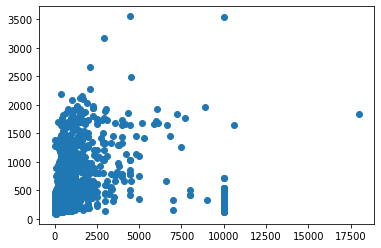

In [77]:
predictions = model.predict_on_batch(X)

plt.scatter(y, predictions)

# the ideal shape of this is an x=y line

In [67]:
dfy.describe()

count    11244.000000
mean       429.080398
std       1296.041387
min          1.000000
25%         80.000000
50%        140.000000
75%        300.000000
max      17999.000000
Name: price, dtype: float64

In [69]:
df[df['price'] > 10000]

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,...,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,am_list,Air conditioning,Dishwasher,Free parking on premises,Kitchen,Garden or backyard,Internet,Suitable for events,entire,private,shared,hotel,East Downtown,Downtown,Travis Heights,University of Texas,East Riverside,Zilker,Bouldin Creek,Barton Hills,South Lamar,MLK & 183,house,apartment,condo
9710,36868625,https://www.airbnb.com/rooms/36868625,20191112224534,2019-11-13,Sapphire on Lake Austin,NaN,NaN,NaN,none,NaN,NaN,NaN,NaN,NaN,All credit card holders must be aged 25 years ...,NaN,NaN,https://a0.muscache.com/4ea/air/v2//pictures/1...,NaN,210733801,https://www.airbnb.com/users/show/210733801,Arrive,2018-08-20,"Austin, Texas, United States",ARRIVE Luxury Property and Vacation Management...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/ee8cf...,https://a0.muscache.com/im/pictures/user/ee8cf...,Rollingwood,38.0,38.0,"['email', 'phone', 'work_email']",t,f,"Austin, TX, United States",Long Canyon,78733,...,NaN,NaN,f,NaN,"{""Texas State""}",t,f,luxury_moderate,f,f,33,33,0,0,NaN,"[Cable TV, Wifi, Pool, Hot tub, Heating, Suita...",False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
10906,39280163,https://www.airbnb.com/rooms/39280163,20191112224534,2019-11-13,*NO GUEST SERVICE FEE* THE ARRIVE RIDGEVIEW LA...,Welcome to The ARRIVE Ridgeview Lakefront Esta...,All ARRIVE estates include a personal concierg...,Welcome to The ARRIVE Ridgeview Lakefront Esta...,none,NaN,NaN,NaN,NaN,NaN,1. The number of guests this property accommod...,NaN,NaN,https://a0.muscache.com/im/pictures/9673c18c-d...,NaN,157959474,https://www.airbnb.com/users/show/157959474,Red Awning,2017-11-08,"Emeryville, California, United States",Red Awning brings hotel-style consistency and ...,within an hour,100%,NaN,f,https://a0.muscache.com/im/pictures/user/5239c...,https://a0.muscache.com/im/pictures/user/5239c...,Long Canyon,24.0,24.0,"['email', 'phone', 'jumio', 'offline_governmen...",t,f,"Austin, TX, United States",Long Canyon,78733,...,NaN,NaN,f,NaN,"{""Texas State""}",t,f,super_strict_30,f,f,23,23,0,0,NaN,"[TV, Cable TV, Internet, Wifi, Air conditionin...",True,True,True,True,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False


In [72]:
df.iloc[10906]['price']

20.0